# Memorizer Data Analysis
Performing exploratory data analysis on Memorizer data

## Imports

In [1]:
# imports here

# data analysis and manipulation
import pandas as pd
# basic graph visualization
import numpy as np
# data visualization
import seaborn as sns
# plotting and data visualization
import matplotlib.pyplot as plt
from matplotlib import pyplot
# graph-like object representation and manipulation
import networkx as nx


import ipywidgets as widgets
import ydata_profiling
from IPython.display import IFrame
import math
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import mariadb
import os
from dotenv import load_dotenv

import dataframe_image as dfi
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from numpy import log
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import datetime
from statsmodels.graphics.tsaplots import plot_acf

## Importing the Database

In [2]:
load_dotenv()

conn = mariadb.connect(
            host=os.getenv("MYSQL_HOST"),
            port=3306,
            user= os.getenv("MYSQL_USER"),
            database=os.getenv('MYSQL_DB'),
            password=os.getenv("MYSQL_PASSWORD")
        )

df = pd.read_sql('SELECT * FROM memorizer', conn)
df.head()

C:\Users\gimli\AppData\Local\Temp\ipykernel_25800\3941416572.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('SELECT * FROM memorizer', conn)


,alloc_ip,pid,obj_ptr,obj_size,alloc_jiffies,free_jiffies,free_ip,type,command,slab,access_ip,writes,rds
0,ffffffffc17ba000,978,ffff88810f4f3dc0,1216,4295012021,4295012029,ffffffffc17bb4cc,KMEM_CACHE_BULK,gnome-shell,drm_i915_gem_object,ffffffff81162863,1,0
1,ffffffffc17ba000,978,ffff88810f4f3dc0,1216,4295012021,4295012029,ffffffffc17bb4cc,KMEM_CACHE_BULK,gnome-shell,drm_i915_gem_object,ffffffff811e0a44,3972,0
2,ffffffffc17ba000,978,ffff88810f4f3dc0,1216,4295012021,4295012029,ffffffffc17bb4cc,KMEM_CACHE_BULK,gnome-shell,drm_i915_gem_object,ffffffff829ad0ad,3971,0
3,ffffffffc17ba000,978,ffff88810f4f3dc0,1216,4295012021,4295012029,ffffffffc17bb4cc,KMEM_CACHE_BULK,gnome-shell,drm_i915_gem_object,ffffffff811102fc,0,13
4,ffffffffc17ba000,978,ffff88810f4f3dc0,1216,4295012021,4295012029,ffffffffc17bb4cc,KMEM_CACHE_BULK,gnome-shell,drm_i915_gem_object,ffffffff8111084b,0,3


## Gaining Understanding of the Dataframe

In [3]:
print('Number of Rows:', df.shape[0])

Number of Rows: 83998243


In [4]:
# exporting png of first 5 rows of dataset
dfi.export(df.head(), 'df_styled.png')

In [5]:
# value counts for alloc ip
ip_counts = df['alloc_ip'].value_counts()
ip_counts

alloc_ip
ffffffff815a2635    13616385
ffffffff82890c7b     7881910
ffffffff817184c7     5434657
ffffffff815a2d3e     4536617
ffffffff815a305c     4163952
                      ...   
ffffffffc17a6e34         159
ffffffff824c25d4         125
ffffffff819b590f          93
ffffffffc17a783b          39
ffffffff8170c0ae          21
Name: count, Length: 143, dtype: int64

In [6]:
# value counts for access ip
ip_counts = df['access_ip'].value_counts()
ip_counts

access_ip
ffffffff81247691    308991
ffffffff812476c5    308991
ffffffff81247699    308991
ffffffff812476a9    308991
ffffffff812476b8    308991
                     ...  
ffffffff819b5952         1
ffffffff819b5965         1
ffffffffc17f82be         1
ffffffff81790d41         1
ffffffff828c1a76         1
Name: count, Length: 22026, dtype: int64

access_ip
ffffffff81247691    308991
ffffffff812476c5    308991
ffffffff81247699    308991
ffffffff812476a9    308991
ffffffff812476b8    308991
ffffffff812476e2    308991
ffffffff812476da    308991
ffffffff812a13fd    256510
ffffffff812a4746    256510
ffffffff812a13f0    256138
ffffffff829af5f7    232959
ffffffff829b1a05    230173
ffffffff81722ba2    217648
ffffffff81722b17    217648
ffffffff8172290d    202570
ffffffff81720821    202124
ffffffff81720a35    202124
ffffffff81716dad    202124
ffffffff81716d9d    202124
ffffffff81716d87    202124
Name: count, dtype: int64

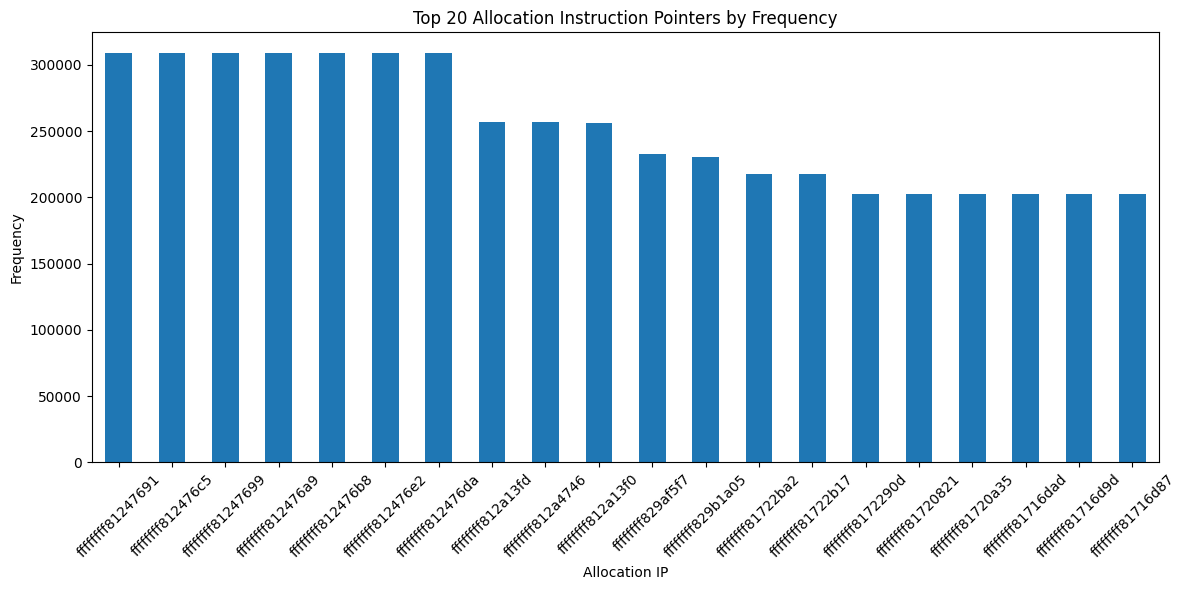

In [7]:
# plotting top 20 ips
top = 20
top_ip_counts = ip_counts.head(top)
display(top_ip_counts)

plt.figure(figsize=(12, 6))
top_ip_counts.plot(kind='bar')
plt.title(f'Top {top} Allocation Instruction Pointers by Frequency')
plt.xlabel('Allocation IP')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('AllocIPs')
plt.show()

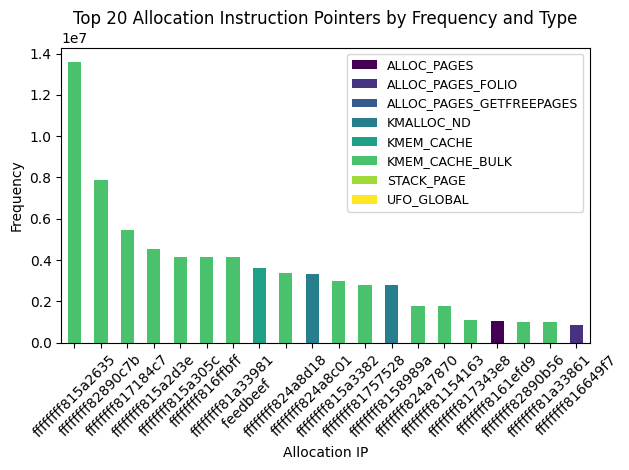

In [8]:
# checking frequency of most common types
grouped_data = df.groupby(['alloc_ip', 'type']).size().unstack(fill_value=0)

top_ip_counts = grouped_data.sum(axis=1).sort_values(ascending=False).head(top)

top_grouped_data = grouped_data.loc[top_ip_counts.index]

top_grouped_data.plot(kind='bar', stacked=True, colormap='viridis')
plt.title(f'Top {top} Allocation Instruction Pointers by Frequency and Type')
plt.xlabel('Allocation IP')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Type of Slab Cache', loc='upper right')
plt.legend(fontsize = 9)
plt.tight_layout()
plt.savefig('AllocIPsType')
plt.show()

In [9]:
df.columns

Index(['alloc_ip', 'pid', 'obj_ptr', 'obj_size', 'alloc_jiffies',
       'free_jiffies', 'free_ip', 'type', 'command', 'slab', 'access_ip',
       'writes', 'rds'],
      dtype='object')

In [10]:
# Testing correlation between alloc jiffies and free jiffies to see if it gives any insight
print('Correlation between alloc jiffies and free jiffies:',df['alloc_jiffies'].corr(df['free_jiffies']))

Correlation between alloc jiffies and free jiffies: 0.9907738937173571


In [11]:
print('Max alloc_jiffies =', df['alloc_jiffies'].max())
print('Min alloc_jiffies =', df['alloc_jiffies'].min())
print('Median alloc_jiffies =', df['alloc_jiffies'].median())
print('Average alloc_jiffies =', df['alloc_jiffies'].mean())

Max alloc_jiffies = 4295048623
Min alloc_jiffies = 4295012021
Median alloc_jiffies = 4295030749.0
Average alloc_jiffies = 4295029475.789104


In [12]:
print('Max free_jiffies =', df['free_jiffies'].max())
print('Min free_jiffies =', df['free_jiffies'].min())
print('Median free_jiffies =', df['free_jiffies'].median())
print('Average free_jiffies =', df['free_jiffies'].mean())

Max free_jiffies = 4295048623
Min free_jiffies = 4295012022
Median free_jiffies = 4295031063.0
Average free_jiffies = 4295029752.634434


In [13]:
print('Max size =', df['obj_size'].max())
print('Min size =', df['obj_size'].min())
print('Median Size =', df['obj_size'].median())
print('Average size =', df['obj_size'].mean())
print('Number of Rows with Minimum Size of 1:', df[df['obj_size'] == 1].shape[0])
print('Number of Rows with Maximum Size of 262144:', df[df['obj_size'] == 32768].shape[0])

Max size = 32768
Min size = 1
Median Size = 320.0
Average size = 2280.070292065514
Number of Rows with Minimum Size of 1: 1770
Number of Rows with Maximum Size of 262144: 37601


In [14]:
# Converting pid to object
df['pid'] = df['pid'].astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83998243 entries, 0 to 83998242
Data columns (total 13 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   alloc_ip       object
 1   pid            object
 2   obj_ptr        object
 3   obj_size       int64 
 4   alloc_jiffies  int64 
 5   free_jiffies   int64 
 6   free_ip        object
 7   type           object
 8   command        object
 9   slab           object
 10  access_ip      object
 11  writes         int64 
 12  rds            int64 
dtypes: int64(5), object(8)
memory usage: 8.1+ GB


In [15]:
# Selecting numerical and categorical variables separately
num_allocs = df.select_dtypes(include='int64')
cat_allocs = df.select_dtypes(include='object')
display(num_allocs.head())
display(cat_allocs.head())

,obj_size,alloc_jiffies,free_jiffies,writes,rds
0,1216,4295012021,4295012029,1,0
1,1216,4295012021,4295012029,3972,0
2,1216,4295012021,4295012029,3971,0
3,1216,4295012021,4295012029,0,13
4,1216,4295012021,4295012029,0,3


,alloc_ip,pid,obj_ptr,free_ip,type,command,slab,access_ip
0,ffffffffc17ba000,978,ffff88810f4f3dc0,ffffffffc17bb4cc,KMEM_CACHE_BULK,gnome-shell,drm_i915_gem_object,ffffffff81162863
1,ffffffffc17ba000,978,ffff88810f4f3dc0,ffffffffc17bb4cc,KMEM_CACHE_BULK,gnome-shell,drm_i915_gem_object,ffffffff811e0a44
2,ffffffffc17ba000,978,ffff88810f4f3dc0,ffffffffc17bb4cc,KMEM_CACHE_BULK,gnome-shell,drm_i915_gem_object,ffffffff829ad0ad
3,ffffffffc17ba000,978,ffff88810f4f3dc0,ffffffffc17bb4cc,KMEM_CACHE_BULK,gnome-shell,drm_i915_gem_object,ffffffff811102fc
4,ffffffffc17ba000,978,ffff88810f4f3dc0,ffffffffc17bb4cc,KMEM_CACHE_BULK,gnome-shell,drm_i915_gem_object,ffffffff8111084b


In [16]:
# Showing number of unique values in each column
n = df.nunique(axis = 0)
print("Number of Unique Values in Each Column :\n", n)

Number of Unique Values in Each Column :
 alloc_ip           143
pid                 77
obj_ptr          15861
obj_size            47
alloc_jiffies    26626
free_jiffies     27919
free_ip            168
type                 8
command             53
slab                96
access_ip        22026
writes             521
rds               1146
dtype: int64


In [17]:
# Converts size in bytes to a more readable format (KB, etc)
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

In [18]:
# Checking some statistics
print("Number of Variables: " + str(len(df.columns)))
print("Number of Observations: " + str(df.shape[0]))
print("Number of Duplicate Rows: " + str(df.duplicated().sum()))
print("Memory Size: " + str(convert_size(df.memory_usage(index=True, deep=True).sum())))
print("Number of Missing Values in each Column: \n" + str(df.isna().sum()))

Number of Variables: 13
Number of Observations: 83998243
Number of Duplicate Rows: 33094101
Memory Size: 40.71 GB
Number of Missing Values in each Column: 
alloc_ip         0
pid              0
obj_ptr          0
obj_size         0
alloc_jiffies    0
free_jiffies     0
free_ip          0
type             0
command          0
slab             0
access_ip        0
writes           0
rds              0
dtype: int64


## Running Analysis and Creating Visualizations

In [19]:
# Creating and displaying wordcloud image of each column
dd = widgets.Dropdown( 
options = cat_allocs.columns,
    description='Select A Column'
)
def draw_wordcloud(column):
    text = " ".join(alloc for alloc in df[column])
    wordcloud = WordCloud().generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print("Number of Distinct: " + str(len(pd.unique(df[column]))))
    print("Number of Missing: " + str(df[column].isna().sum()))
widgets.interact(draw_wordcloud, column=dd)

interactive(children=(Dropdown(description='Select A Column', options=('alloc_ip', 'pid', 'obj_ptr', 'free_ip'…

<function __main__.draw_wordcloud(column)>

In [20]:
# Creating html report of data
profile = ydata_profiling.ProfileReport(df)
profile.to_file(output_file='output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\gimli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ydata_profiling\model\pandas\summary_pandas.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.fillna(np.nan)
C:\Users\gimli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ydata_profiling\model\correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(inc

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
url = 'output.html'
IFrame(url, width=700, height=1000)

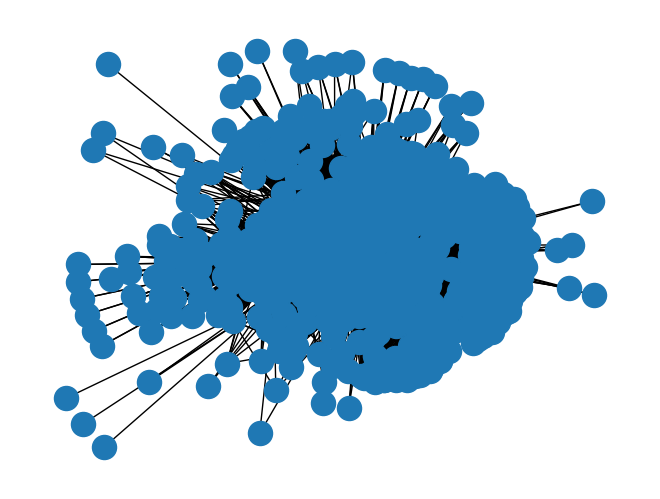

In [22]:
# Graph 1
# alloc_ip, writes
G = nx.MultiGraph()
graphdf = df[['writes', 'alloc_ip']]
G=nx.from_pandas_edgelist(graphdf, 'writes', 'alloc_ip')
nx.draw(G)

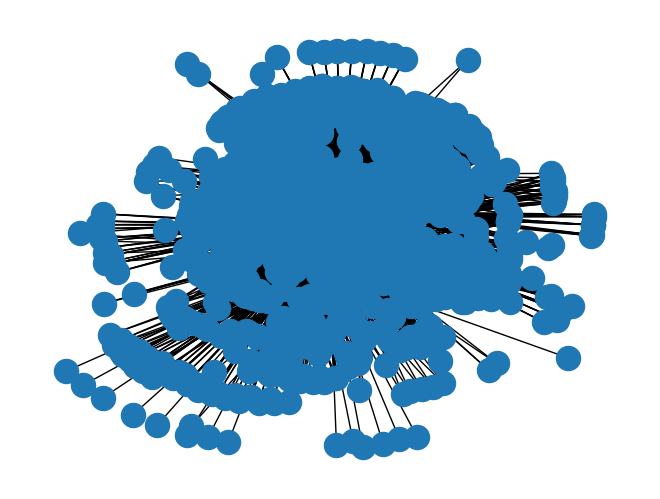

In [23]:
# Graph 2
# access_ip, writes
G = nx.MultiGraph()
graphdf = df[['rds', 'alloc_ip']]
G=nx.from_pandas_edgelist(graphdf, 'rds', 'alloc_ip')
nx.draw(G)

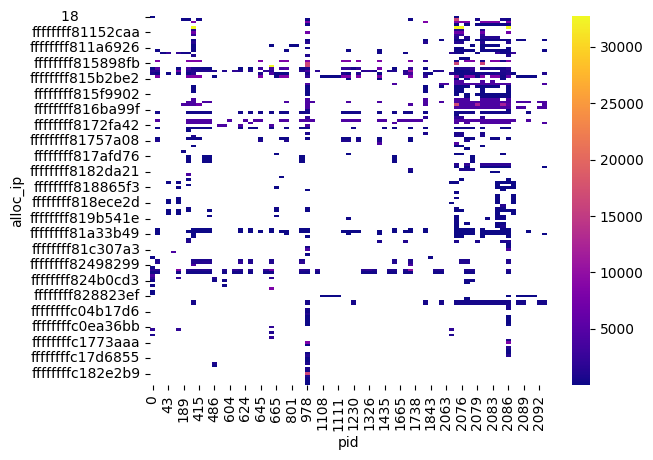

In [24]:
# Heatmap
# alloc_ip and pid based on obj_size
df_matrix = df.pivot_table(index="alloc_ip", columns="pid", values="obj_size")
sns.heatmap(df_matrix, cmap="plasma", annot=False, fmt="d")
plt.savefig('heatmap1')
plt.show()

In [25]:
# Features Matrix
X = df.drop(columns = 'slab')

# Target Array
y = df['slab']

In [26]:
# Splitting into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.30)
print('Checking Test is 30% of Full Dataset:', (len(X_test)/len(df))*100, '%')
X_train.head()

Checking Test is 30% of Full Dataset: 30.000000119050107 %


,alloc_ip,pid,obj_ptr,obj_size,alloc_jiffies,free_jiffies,free_ip,type,command,access_ip,writes,rds
61676234,ffffffff815a2635,978,ffff8881059ea000,4096,4295037697,4295037707,ffffffffc182e53c,KMEM_CACHE_BULK,gnome-shell,ffffffffc081f54b,0,1
78589914,ffffffff815a2d3e,1735,ffff888121a28000,16384,4295045563,4295045563,000000000fedbeef,KMEM_CACHE_BULK,gnome-system-mo,ffffffff824bf336,0,1
40804753,ffffffff815a2635,978,ffff88812913bc00,1024,4295029986,4295030058,ffffffffc18be338,KMEM_CACHE_BULK,gnome-shell,ffffffffc18cb379,0,12
30379351,ffffffff81a33981,1735,ffff888126d7e208,40,4295024432,4295024435,ffffffff81a32866,KMEM_CACHE_BULK,gnome-system-mo,ffffffff81735e0e,1,0
7626100,ffffffff817184c7,796,ffff888106ad0000,4352,4295013686,4295013686,ffffffff81716e06,KMEM_CACHE_BULK,systemd,ffffffff816ffc88,1,0


### Time Series Analysis

In [27]:
# Changing jiffies to numeric for time series analysis
df['alloc_jiffies'] = pd.to_numeric(df['alloc_jiffies'], errors='coerce')
df['free_jiffies'] = pd.to_numeric(df['free_jiffies'], errors='coerce')
df.head()

,alloc_ip,pid,obj_ptr,obj_size,alloc_jiffies,free_jiffies,free_ip,type,command,slab,access_ip,writes,rds
0,ffffffffc17ba000,978,ffff88810f4f3dc0,1216,4295012021,4295012029,ffffffffc17bb4cc,KMEM_CACHE_BULK,gnome-shell,drm_i915_gem_object,ffffffff81162863,1,0
1,ffffffffc17ba000,978,ffff88810f4f3dc0,1216,4295012021,4295012029,ffffffffc17bb4cc,KMEM_CACHE_BULK,gnome-shell,drm_i915_gem_object,ffffffff811e0a44,3972,0
2,ffffffffc17ba000,978,ffff88810f4f3dc0,1216,4295012021,4295012029,ffffffffc17bb4cc,KMEM_CACHE_BULK,gnome-shell,drm_i915_gem_object,ffffffff829ad0ad,3971,0
3,ffffffffc17ba000,978,ffff88810f4f3dc0,1216,4295012021,4295012029,ffffffffc17bb4cc,KMEM_CACHE_BULK,gnome-shell,drm_i915_gem_object,ffffffff811102fc,0,13
4,ffffffffc17ba000,978,ffff88810f4f3dc0,1216,4295012021,4295012029,ffffffffc17bb4cc,KMEM_CACHE_BULK,gnome-shell,drm_i915_gem_object,ffffffff8111084b,0,3


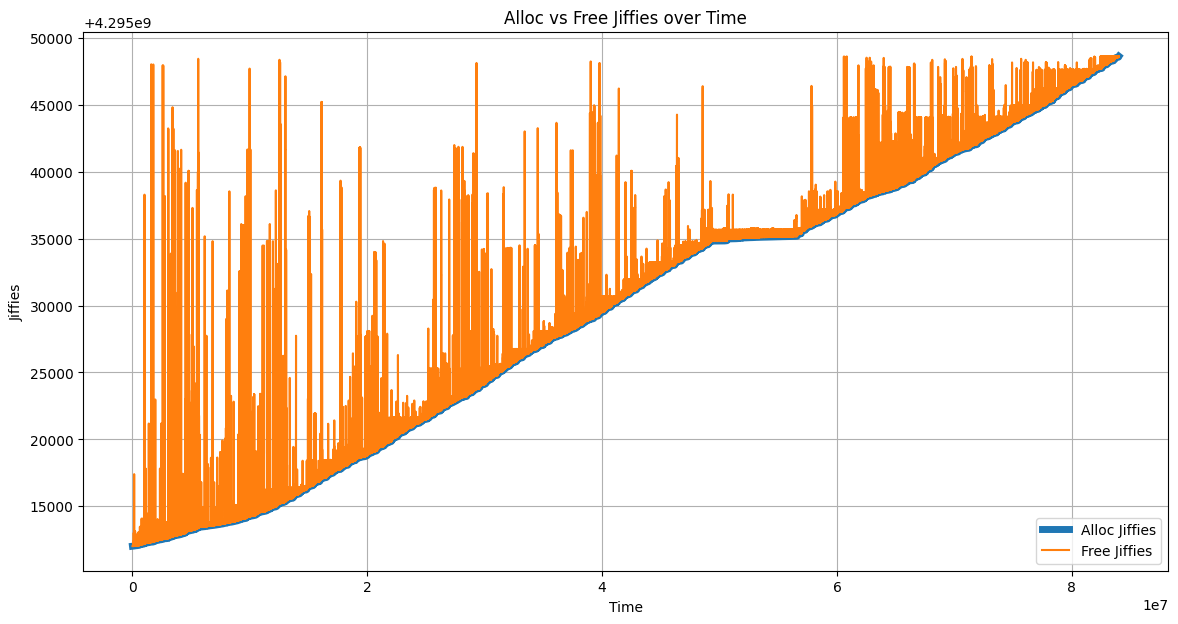

In [28]:
# Plotting time series analysis graph
plt.figure(figsize=(14, 7))
plt.plot(df['alloc_jiffies'], label='Alloc Jiffies', linewidth = 5)
plt.plot(df['free_jiffies'], label='Free Jiffies')
plt.title('Alloc vs Free Jiffies over Time')
plt.xlabel('Time')
plt.ylabel('Jiffies')
plt.legend()
plt.grid(True)
plt.savefig('TimeSeriesPlot')
plt.show()

In [29]:
pyplot.plot(allocjiffies)

NameError: name 'allocjiffies' is not defined

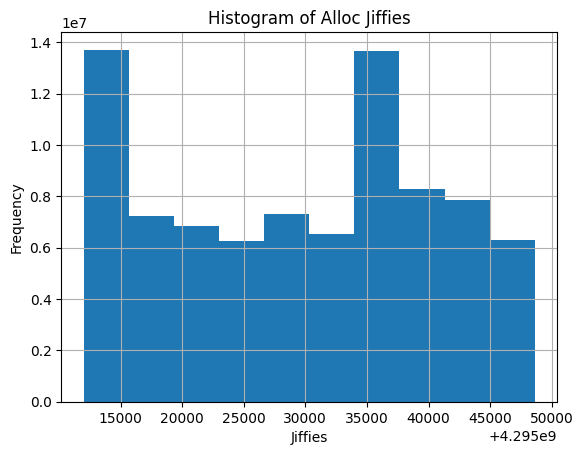

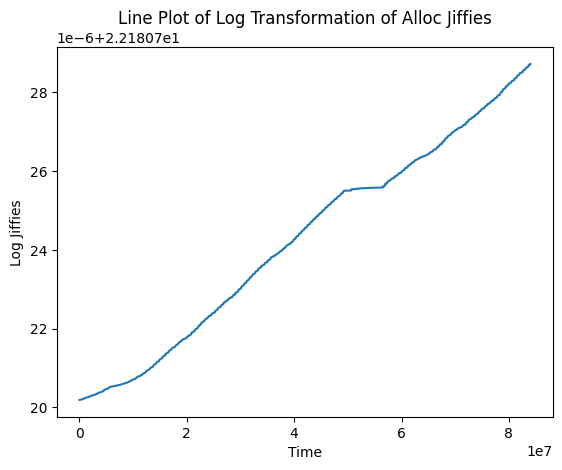

In [ ]:
# Creating histogram and line plot of alloc jiffies
allocjiffies = df['alloc_jiffies']
allocjiffies.hist()
plt.title('Histogram of Alloc Jiffies')
plt.xlabel('Jiffies')
plt.ylabel('Frequency')
plt.savefig('HistAlloc')
plt.show()

logallocjiffies = log(allocjiffies)
pyplot.plot(logallocjiffies)
plt.title('Line Plot of Log Transformation of Alloc Jiffies')
plt.ylabel('Log Jiffies')
plt.xlabel('Time')
plt.savefig('AllocPyplot')
plt.show()

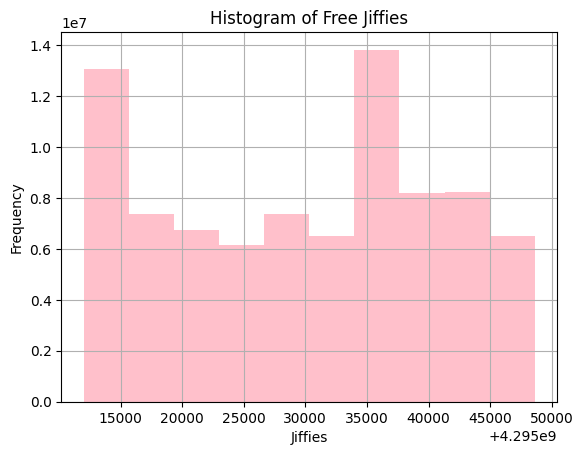

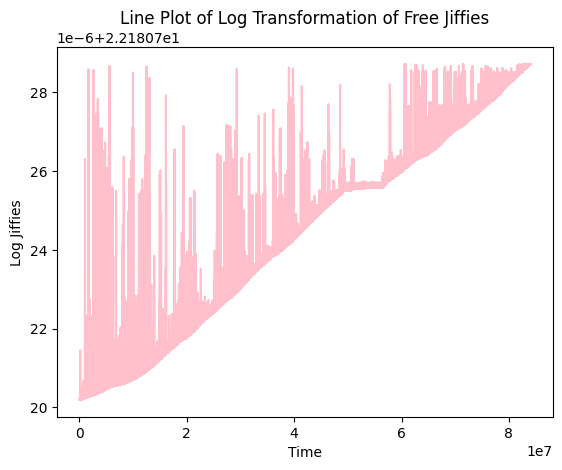

In [ ]:
# Creating histogram and line plot of free jiffies
freejiffies = df['free_jiffies']
freejiffies.hist(color = 'pink')
plt.title('Histogram of Free Jiffies')
plt.xlabel('Jiffies')
plt.ylabel('Frequency')
plt.savefig('HistFree')
plt.show()

logfreejiffies = log(freejiffies)
pyplot.plot(logfreejiffies, color = 'pink')
plt.title('Line Plot of Log Transformation of Free Jiffies')
plt.ylabel('Log Jiffies')
plt.xlabel('Time')
plt.savefig('FreePyplot')
plt.show()

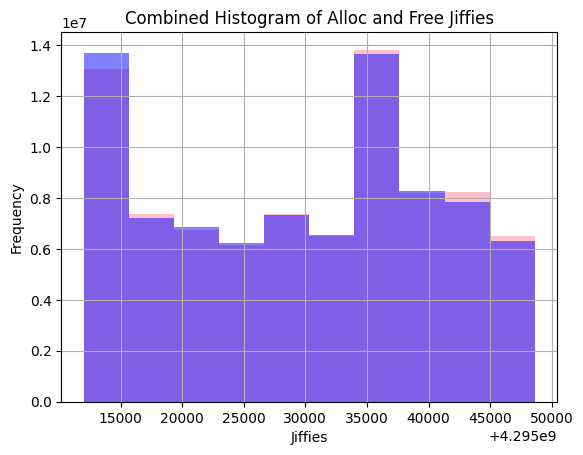

In [ ]:
freejiffies.hist(color = 'pink')
allocjiffies.hist(color = 'blue', alpha = 0.5)
plt.title('Combined Histogram of Alloc and Free Jiffies')
plt.xlabel('Jiffies')
plt.ylabel('Frequency')
plt.savefig('HistComb')
plt.show()

In [ ]:
# Gives us insights on stationarity
# alloc_jiffies
values = df['alloc_jiffies'].values
split = round(len(values)/2)
values1, values2 = values[0:split], values[split:]
mean1, mean2 = values1.mean(), values2.mean()
var1, var2 = values1.var(), values2.var()
print('mean1 = %f, mean2 = %f' % (mean1,mean2))
print('variance1 = %f, variance2 = %f' %(var1, var2))

mean1 = 4295020023.245228, mean2 = 4295038928.333198
variance1 = 32986949.415793, variance2 = 23472927.036242


In [ ]:
# Gives us insights on stationarity
# free_jiffies
values = df['free_jiffies'].values
split = round(len(values)/2)
values1, values2 = values[0:split], values[split:]
mean1, mean2 = values1.mean(), values2.mean()
var1, var2 = values1.var(), values2.var()
print('mean1 = %f, mean2 = %f' % (mean1,mean2))
print('variance1 = %f, variance2 = %f' %(var1, var2))

mean1 = 4295020388.850986, mean2 = 4295039116.418139
variance1 = 36596255.461385, variance2 = 23618606.573050


In [ ]:
# Checking Stationarity - the statistical concept in which the way a time series changes over time stays consistent - using ADF test
# alloc jiffies
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
test_stationarity(allocjiffies.sample(frac = 0.009))

ADF Statistic: 0.001670369470396647
p-value: 0.9586700066423515
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [ ]:
# Checking Stationarity - the statistical concept in which the way a time series changes over time stays consistent
# free jiffies
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test - test used to check stationarity; type of unit root test
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
test_stationarity(freejiffies.sample(frac = 0.009))

ADF Statistic: 0.007043367512995908
p-value: 0.9591107060507044
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


Since the test wouldn't run a full dataset, a smaller sample was used. The largest amount of data that was able to run a test was 0.9%, as shown above. Looking at the results for `alloc_jiffies`, we have a test statistic of 0.0017 and a p-value of 0.9587. Using a significance level of $\alpha$ = 0.05, we fail to reject the null hypothesis. There is not sufficient evidence to support that the time series is stationary.

Looking at the results for `free_jiffies`, we have a test statistic of 0.0070 and a p-value of 0.9591. Using a significance level of $\alpha$ = 0.05, we fail to reject the null hypothesis. There is not sufficient evidence to support that the time series is stationary.

Stationarity in a dataset matters because it tells us we can be confident in trends and patterns we observe in a dataset aren't due to fluctuations in the data. Essentially, stationarity gives us confidence in our data analysis. In order to help gain this confidence, we will split up the time series then see where the issues lie.

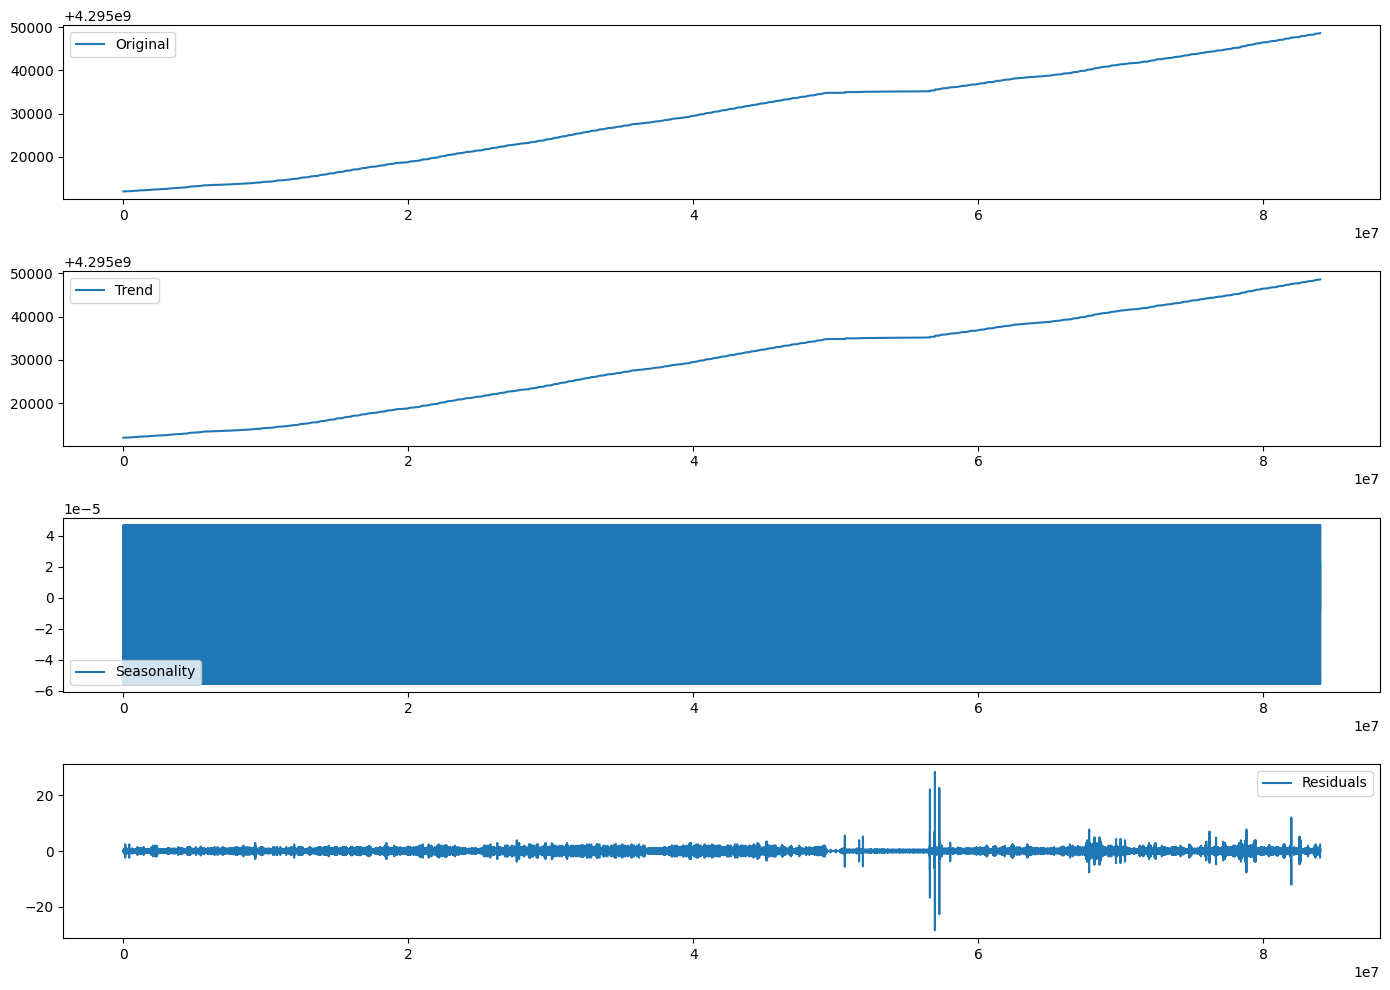

In [ ]:
# Decompose the time series to analyze trends, seasonality, and residuals
# alloc_jiffies
decomposition = seasonal_decompose(df['alloc_jiffies'], model='additive', period=30)  # Adjust period as needed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(df['alloc_jiffies'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('AllocDecomp')

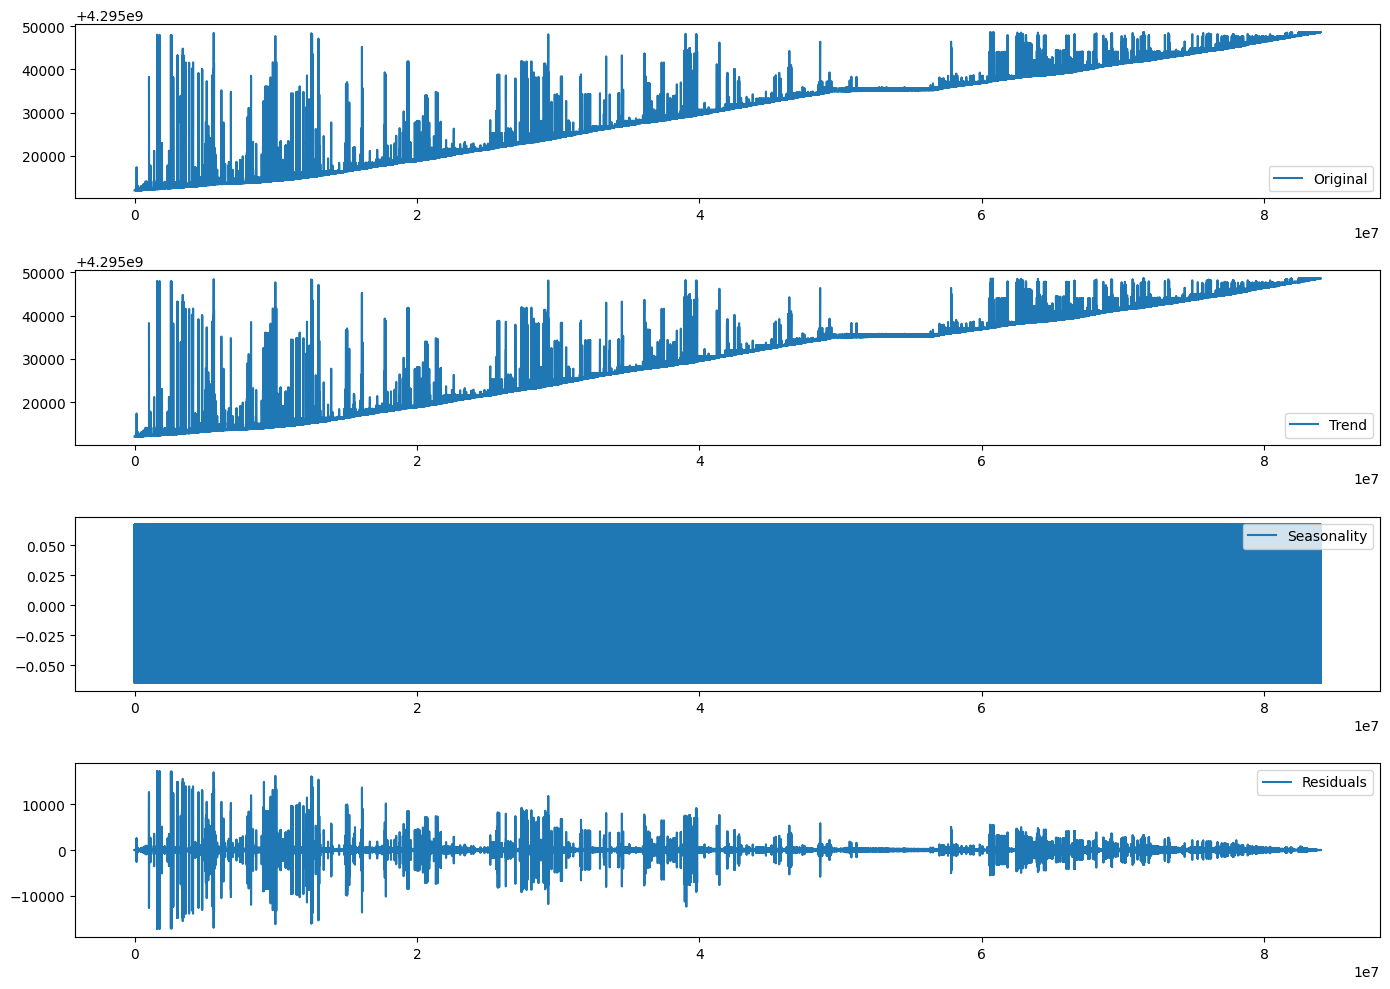

In [ ]:
# Decompose the time series to analyze trends, seasonality, and residuals
# free_jiffies
decomposition = seasonal_decompose(df['free_jiffies'], model='additive', period=30)  # Adjust period as needed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(df['free_jiffies'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('FreeDecomp')

Time series decomposition breaks the time series into three components: trend, seasonality, and residuals (cycles)...

**Trend**: Shows the general direction the data is moving over a period of time. Basically, it shows the movement of the data.

**Seasonality**: Shows the cycles/trends in the data that are repetitive. Referred to as seasonality as it is influenced by seasonal factors, such as monthly or yearly cycles.

**Residuals**: Commonly referred to as the "noise" component, this section shows irregularities in the data.